In [1]:
#private github repo - cara
#git@github.com:ronocara/Autoencoders-MURA.git
#git@github.com:aronnicksnts/MURA-Classification.git

In [5]:
from vae import *
from image_manipulation import *
import pandas as pd
import numpy as np
from numpy import asarray
import cv2
import matplotlib.pyplot as plt
from PIL import Image

#AE model
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from torchvision import models
from torchvision import transforms
from torchsummary import summary
import torch

#for metrics
from sklearn.metrics import roc_curve, auc
from tensorflow.keras.optimizers import Adam


##### Pre-processing on a single image

In [3]:
#getting sample image from positives dataset
image_loc = '/home/cara/Thesis/MURA-v1.1/train/XR_HUMERUS/patient02626/study1_positive/image2.png'

In [6]:
#resize image first then restart notebook skip this and continue with next one
f_img = image_loc 
img = Image.open(f_img)
img = img.resize((64,64))
img.save(f_img)

In [7]:
#reading single image and apply preprocessing

image = cv.imread(image_loc , cv.IMREAD_GRAYSCALE)
adaptive_image = adaptive_histogram(image)
watershed_image = watershed(image) 

In [8]:
print('image shape: ', image.shape)

image shape:  (64, 64)


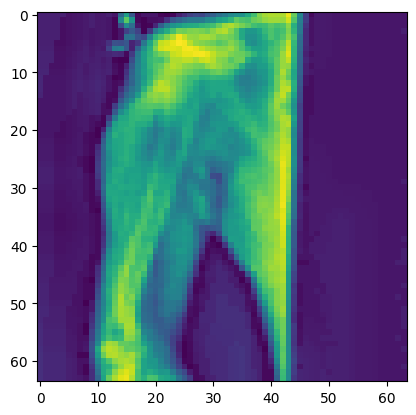

In [9]:
plt.imshow(adaptive_image)

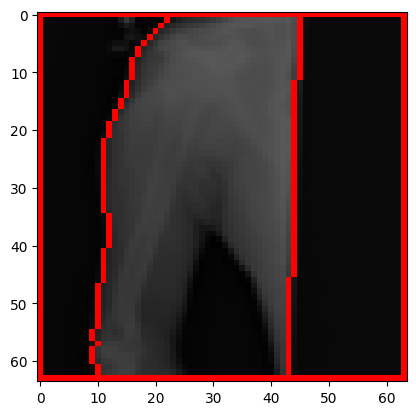

In [10]:
#Input
plt.imshow(watershed_image)

In [11]:
#normalizing images
watershed_image.astype('float32') / 255.

#reshape image
processed_image = np.reshape(watershed_image, (1,64,64,3))


In [12]:
processed_image

array([[[[255,   0,   0],
         [255,   0,   0],
         [255,   0,   0],
         ...,
         [255,   0,   0],
         [255,   0,   0],
         [255,   0,   0]],

        [[255,   0,   0],
         [  8,   8,   8],
         [  8,   8,   8],
         ...,
         [  9,   9,   9],
         [  9,   9,   9],
         [255,   0,   0]],

        [[255,   0,   0],
         [  8,   8,   8],
         [  8,   8,   8],
         ...,
         [  9,   9,   9],
         [  9,   9,   9],
         [255,   0,   0]],

        ...,

        [[255,   0,   0],
         [  6,   6,   6],
         [  6,   6,   6],
         ...,
         [  9,   9,   9],
         [  9,   9,   9],
         [255,   0,   0]],

        [[255,   0,   0],
         [  6,   6,   6],
         [  6,   6,   6],
         ...,
         [  9,   9,   9],
         [  9,   9,   9],
         [255,   0,   0]],

        [[255,   0,   0],
         [255,   0,   0],
         [255,   0,   0],
         ...,
         [255,   0,   0],
        

In [13]:
print('image shape: ', processed_image.shape)

image shape:  (1, 64, 64, 3)


## Vanilla Autoencoder

In [14]:
multiplier = 4
latentDim=2048
input_shape=(64,64,3)

Training Autoencoder

In [15]:
encoder, decoder, autoencoder = Autoencoder.build(input_shape, multiplier, latentDim)


2023-04-10 11:41:46.826148: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [16]:
print(encoder.summary())

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 64)        3136      
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 64)       256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 32, 32, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       131200    
                                                                 
 batch_normalization_1 (Batc  (None, 16, 16, 128)      512       
 hNormalization)                                           

In [17]:

print(decoder.summary())

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2048)]            0         
                                                                 
 dense_1 (Dense)             (None, 4096)              8392704   
                                                                 
 reshape (Reshape)           (None, 4, 4, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 8, 8, 256)        1048832   
 nspose)                                                         
                                                                 
 batch_normalization_4 (Batc  (None, 8, 8, 256)        1024      
 hNormalization)                                                 
                                                                 
 activation_4 (Activation)   (None, 8, 8, 256)         0   

In [18]:
print(autoencoder.summary())

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 encoder (Functional)        (None, 2048)              10101184  
                                                                 
 decoder (Functional)        (None, 64, 64, 3)         10101955  
                                                                 
Total params: 20,203,139
Trainable params: 20,200,835
Non-trainable params: 2,304
_________________________________________________________________
None


In [19]:
optimizer = Adam(learning_rate=0.01)
autoencoder.compile(optimizer=optimizer, loss='mse', 
                    metrics=['mse', tf.keras.metrics.AUC(name='AUC'),
                             tf.keras.metrics.Precision(name='Precision'),
                             tf.keras.metrics.Recall(name='Recall'),
                             tf.keras.metrics.TruePositives(name='True Positives'), 
                             tf.keras.metrics.TrueNegatives(name='True Negatives'),
                             tf.keras.metrics.FalsePositives(name='False Positives'),
                             tf.keras.metrics.FalseNegatives(name='False Negatives')
                             ]
                    )

In [20]:
model = autoencoder.fit(processed_image, processed_image,
                epochs=300,
                batch_size=1,
                )

Epoch 1/300
1/1 [==============================] - 4s 4s/step - loss: 3552.3433 - mse: 3552.3433 - AUC: 0.5752 - Precision: 0.9791 - Recall: 0.1911 - True Positives: 2204.0000 - True Negatives: 705.0000 - False Positives: 47.0000 - False Negatives: 9332.0000
Epoch 2/300
1/1 [==============================] - 0s 424ms/step - loss: 3464.3730 - mse: 3464.3730 - AUC: 0.7596 - Precision: 0.9781 - Recall: 0.7702 - True Positives: 8885.0000 - True Negatives: 553.0000 - False Positives: 199.0000 - False Negatives: 2651.0000
Epoch 3/300
1/1 [==============================] - 0s 411ms/step - loss: 3353.2764 - mse: 3353.2764 - AUC: 0.7719 - Precision: 0.9725 - Recall: 0.6619 - True Positives: 7636.0000 - True Negatives: 536.0000 - False Positives: 216.0000 - False Negatives: 3900.0000
Epoch 4/300
1/1 [==============================] - 0s 406ms/step - loss: 3266.7170 - mse: 3266.7170 - AUC: 0.7728 - Precision: 0.9750 - Recall: 0.8421 - True Positives: 9715.0000 - True Negatives: 503.0000 - False P

In [20]:
generated = autoencoder.predict(processed_image)
generated

1/1 [==============================] - 0s 286ms/step


array([[[[2.6261469e+02, 0.0000000e+00, 0.0000000e+00],
         [2.6192404e+02, 0.0000000e+00, 0.0000000e+00],
         [2.6054587e+02, 0.0000000e+00, 0.0000000e+00],
         ...,
         [2.5751352e+02, 0.0000000e+00, 0.0000000e+00],
         [2.5841183e+02, 0.0000000e+00, 0.0000000e+00],
         [2.6288968e+02, 0.0000000e+00, 0.0000000e+00]],

        [[2.5760699e+02, 0.0000000e+00, 0.0000000e+00],
         [5.3831205e+00, 7.9630399e+00, 7.6095772e+00],
         [1.6533263e+00, 6.6818333e+00, 6.6908236e+00],
         ...,
         [7.2785654e+00, 5.9232411e+00, 5.1064196e+00],
         [4.3695936e+00, 8.5515881e+00, 9.5819836e+00],
         [2.6634634e+02, 0.0000000e+00, 0.0000000e+00]],

        [[2.5130084e+02, 0.0000000e+00, 0.0000000e+00],
         [3.2874837e+00, 8.9563866e+00, 9.2896395e+00],
         [1.3581580e-01, 7.9613218e+00, 7.7890501e+00],
         ...,
         [8.2109671e+00, 7.0977960e+00, 7.2125139e+00],
         [2.2499297e+00, 9.9411564e+00, 9.6642685e+00],
  

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


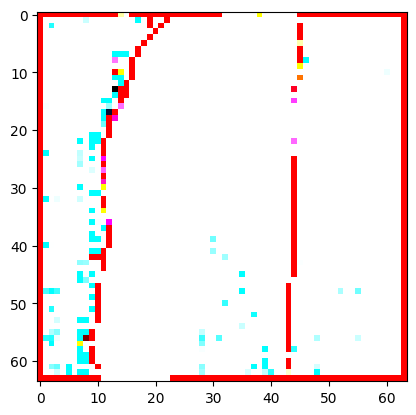

In [21]:
plt.imshow(generated.reshape(64,64,3))
plt.show()

Reconstructed Image

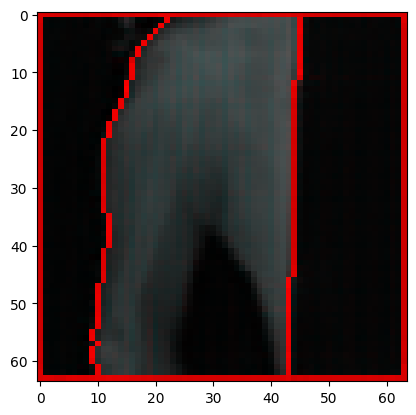

In [22]:
#rescaling image
generated_rescaled = (generated - generated.min()) / (generated.max() - generated.min())

# display the rescaled image
plt.imshow(generated_rescaled.reshape(64,64,3))
plt.show()



#### Plotting performance


In [23]:
metrics = autoencoder.evaluate(processed_image, generated_rescaled)
print(f"MSE: {metrics[1]}")
print(f"AUC: {metrics[2]}")
print(f"Precision: {metrics[3]}")
print(f"Recall: {metrics[4]}")
print(f"True Positives: {metrics[5]}")
print(f"True Negatives: {metrics[6]}")
print(f"False Positives: {metrics[7]}")
print(f"False Negatives: {metrics[8]}")

1/1 [==============================] - 1s 871ms/step - loss: 3862.7310 - mse: 3862.7310 - AUC: 1.0000 - Precision: 1.0000 - Recall: 0.9975 - True Positives: 11538.0000 - True Negatives: 721.0000 - False Positives: 0.0000e+00 - False Negatives: 29.0000
MSE: 3862.73095703125
AUC: 0.9999567866325378
Precision: 1.0
Recall: 0.9974928498268127
True Positives: 11538.0
True Negatives: 721.0
False Positives: 0.0
False Negatives: 29.0


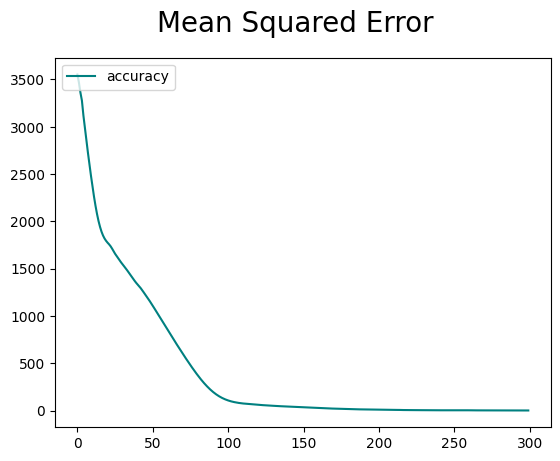

In [24]:
fig = plt.figure()
plt.plot(model.history['mse'], color='teal', label='accuracy')
fig.suptitle('Mean Squared Error', fontsize=20)
plt.legend(loc="upper left")
plt.show()